# Dependencies

In [1]:
%%capture
!pip install pandas
!pip install openai
!pip install seaborn
!pip install tensorflow
!pip install scikit-learn
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [2]:
import os
import json
import random
import string
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display, Image

import cv2
import openai
import pandas as pd
import seaborn as sns
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from mediapipe.framework.formats import landmark_pb2
from sklearn.utils import check_random_state as sklear_set_seed

In [3]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
cv2.setRNGSeed(seed)
sklear_set_seed(seed)
tf. random.set_seed(seed)

# Prepare dataset

In [66]:
possible_categories = [letter.lower() for i, letter in enumerate(string.ascii_uppercase) if letter not in ['J', 'Z']]
#possible_categories.append("*")
#possible_categories.extend([str(x) for x in range(0, 10)])
possible_categories.remove("r")

def load_dataset_from_csv(path, keep_every=1):
    df = pd.read_csv(path, dtype={63: str}, header=None)
    df = df[df[63].notna() & df[63].apply(lambda l: str(l).lower()).isin(possible_categories)]
    if keep_every > 1:
        df = df[df.index % keep_every == 0]
    df[63] = df[63].apply(lambda l: l.lower())
    return df

In [67]:
mnist_df = load_dataset_from_csv("mnist_dataset.csv")
owndataset_a = load_dataset_from_csv("fehervali_lamp_night_webcam.csv", keep_every=10)
owndataset_b = load_dataset_from_csv("zsolca_afternoon_natural_light_lenovo.csv", keep_every=3)
owndataset_c = load_dataset_from_csv("fehervari_afternoon_desktop.csv", keep_every=1)
exter_df = pd.DataFrame()
for p in ["A", "B", "C", "D", "E"]:
    exported_df = load_dataset_from_csv(f"exter_{p}.csv")
    exter_df = pd.concat([exter_df, exported_df])

train_df = pd.concat([exter_df, owndataset_b, mnist_df])
# test_df = owndataset_a

In [68]:
to_remove = list(set(owndataset_c[63].values))

In [69]:
owndataset_a = owndataset_a[~owndataset_a[63].isin(to_remove)]

In [70]:
test_df = pd.concat([owndataset_c, owndataset_a])

In [71]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,0.251722,0.396215,-7.796884e-07,0.163715,0.368139,-0.050717,0.119784,0.290150,-0.080220,0.143277,...,0.385016,0.223121,-0.126935,0.396170,0.264067,-0.117182,0.407536,0.287858,-0.097004,a
2,0.521232,0.606048,-2.290351e-06,0.322461,0.554926,-0.037701,0.174903,0.415615,-0.041737,0.144971,...,0.675350,0.230206,-0.108045,0.645736,0.326114,-0.062056,0.668879,0.367660,-0.010600,a
3,0.538918,0.639175,-2.834356e-06,0.323180,0.549766,-0.030487,0.192804,0.398647,-0.030356,0.195611,...,0.841800,0.291001,-0.109665,0.762186,0.374434,-0.049502,0.780201,0.417881,0.015624,a
4,0.460282,0.655007,-3.090713e-06,0.266203,0.542022,-0.029154,0.164493,0.379913,-0.036292,0.192434,...,0.801347,0.320147,-0.151415,0.703260,0.406675,-0.078538,0.732647,0.447070,-0.003567,a
5,0.494180,0.650316,-2.835134e-06,0.292218,0.533636,-0.033458,0.190409,0.372513,-0.045985,0.214531,...,0.802053,0.342537,-0.167153,0.708577,0.424137,-0.095208,0.748033,0.451378,-0.024948,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8491,0.369939,0.800431,-1.175024e-06,0.568648,0.748469,-0.070642,0.778073,0.596893,-0.091481,0.894302,...,0.332051,0.235386,-0.071189,0.348136,0.357786,-0.040569,0.336142,0.444983,0.001340,a
8492,0.441232,0.782634,1.079454e-06,0.584466,0.722115,-0.083017,0.655162,0.597157,-0.099943,0.627826,...,0.348335,0.457703,-0.106890,0.389506,0.517496,-0.104652,0.405987,0.579272,-0.085727,v
8493,0.162007,0.866955,-5.937231e-07,0.258579,0.657589,-0.046136,0.318701,0.433803,-0.076885,0.353512,...,0.396930,0.723959,-0.196013,0.392359,0.761047,-0.179334,0.335087,0.788474,-0.166086,t
8494,0.585837,0.881295,2.342247e-07,0.757186,0.718931,-0.063724,0.855525,0.486295,-0.073750,0.740707,...,0.335893,0.404316,-0.068321,0.426936,0.491291,-0.070565,0.485583,0.591797,-0.046806,n


In [74]:
def equalize_category_counts(df, category_column):
    # Group by category and find the maximum size
    max_size = df.groupby(category_column).size().max()

    # Resample each group
    resampled = [group.sample(max_size, replace=True) for _, group in df.groupby(category_column)]

    # Concatenate the resampled groups
    return pd.concat(resampled, ignore_index=True)

In [78]:
train_df = equalize_category_counts(train_df, 63)
test_df = equalize_category_counts(test_df, 63)

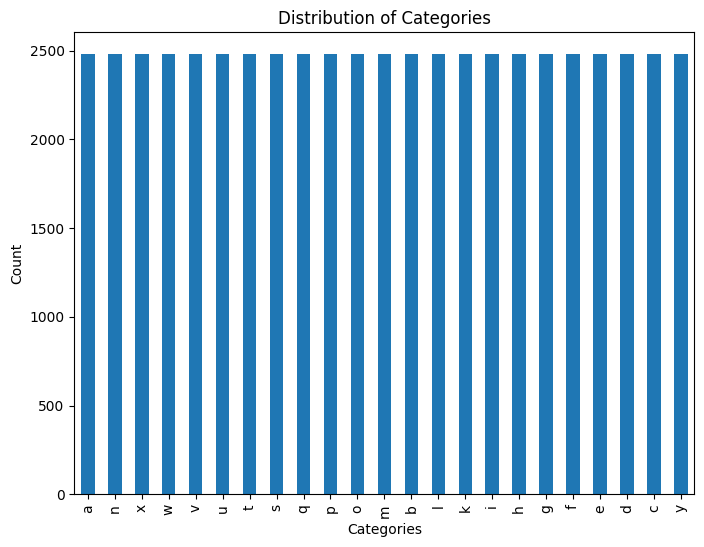

In [79]:
category_counts = train_df[63].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title(f'Distribution of Categories')
plt.savefig('Distribution of Categories.png', dpi=300)  # High resolution
plt.show()

In [80]:
PATH_TRAIN_DS = "train_ds.csv"
PATH_VALID_DS = "valid_ds.csv"
PATH_TEST_DS = "test_ds.csv"
train_df = train_df.sample(frac=1).reset_index(drop=True)

train_df, valid_df = train_test_split(train_df, train_size=0.8, shuffle=True)

train_df.to_csv(PATH_TRAIN_DS, index=False)
valid_df.to_csv(PATH_VALID_DS, index=False)
test_df.to_csv(PATH_TEST_DS, index=False)

# Load dataset

## Preprocess labels

In [81]:
sorted_cats = sorted(set(train_df[63].apply(lambda c: str(c))))
cat_to_num = {sign : i for i, sign in enumerate(sorted_cats)}
num_to_cat = {i : sign for sign, i in cat_to_num.items()}

with open("num_to_cat.json", "w") as json_file:
    json.dump(num_to_cat, json_file)

tf_cat_to_num = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(cat_to_num.keys()),
        values=list(cat_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="signs"
)

def preprocess_cat(cat):
    return tf_cat_to_num.lookup(cat)

## Preprocess + Augment landmarks

Data is flat like this: x1,y1,z1, x2,y2,z2 ....

In [82]:
def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

def scale_hand_lms(flat_xyz, target_size=0.55):
    # Reshape flat data to [num_samples, 3]
    xyz = tf.reshape(flat_xyz, [21, 3]) # 21 coords for the hands

    # Take only the x and y coordinates
    xy = xyz[:, :2]
    
    # Compute the bounding box while ignoring NaN values
    # Note:
    # augment_lms depends on this condition as it can produce values outside of [0, 1]
    # so if this needs to change to ignore values like that make sure to think about augment_lms
    mask = tf.reduce_all(xy != float('nan'), axis=1)
    valid_landmarks = tf.boolean_mask(xy, mask)
    
    # Compute the bounding box
    min_coords = tf.reduce_min(valid_landmarks, axis=0)
    max_coords = tf.reduce_max(valid_landmarks, axis=0)
    
    # Compute the scale factor
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    scale_factor = target_size / tf.maximum(width, height)
    
    # Apply the scaling
    scaled_xy = xy * scale_factor

    # Compute the translation required to move the center of the bounding box to (0.5, 0.5)
    scaled_center = (tf.reduce_min(scaled_xy, axis=0) + tf.reduce_max(scaled_xy, axis=0)) / 2
    translation = [0.5, 0.5] - scaled_center
    
    # Apply the translation to the scaled landmarks
    translated_xy = scaled_xy + translation

    # Stitch back to original shape
    xyz = tf.stack([translated_xy[:, 0], translated_xy[:, 1], xyz[:, 2]], axis=1)
    lms = tf.reshape(xyz, [-1])
    
    return lms

def augment_lms(flat_xyz,
               flip_prob=0.3,
               zoom_prob=0.0,
               scale_prob=0.3,
               shear_prob=0.3,
               shift_prob=0.0,
               rotation_prob=0.3,
               scale=(0.8, 1.2),
               shear=(-0.3, 0.3),
               shift=(-0.01, 0.02),
               degree=(-25, 25),
               zoom=(0.8, 1.1)):
    
    # Reshape flat data to [num_samples, 3]
    xyz = tf.reshape(flat_xyz, [21, 3]) # 21 coords for the hands
    
    # 1. Flip x coordinates with given probability
    if tf.random.uniform(()) <= flip_prob:
        xyz = tf.stack([1-xyz[:, 0], xyz[:, 1], xyz[:, 2]], axis=1)
    
    # Apply zoom with given probability
    if tf.random.uniform(()) <= zoom_prob:
        zx = zy = tf.random.uniform((), *zoom)
    else:
        zx, zy = 1.0, 1.0
    
    # Scale
    if tf.random.uniform(()) <= scale_prob:
        # Random scale factors for x and y
        sx = tf.random.uniform((), *scale)
        sy = tf.random.uniform((), *scale)
        sx *= zx
        sy *= zy
    else:
        sx = zx
        sy = zy

    # Random shear factors for x and y
    if tf.random.uniform(()) <= shear_prob:
        shx = tf.random.uniform((), *shear)
        shy = tf.random.uniform((), *shear)
    else:
        shx = 0.
        shy = 0.

    # Random shift for x and y
    if tf.random.uniform(()) <= shift_prob:
        tx = tf.random.uniform((), *shift)
        ty = tf.random.uniform((), *shift)
    else:
        tx = 0.
        ty = 0.

     # Random rotation in radians
    if tf.random.uniform(()) <= rotation_prob:
        pi_on_180 = 0.017453292519943295
        theta = tf.random.uniform((), degree[0]*pi_on_180, degree[1]*pi_on_180)
    else:
        theta = 0.
        
    c, s = tf.cos(theta), tf.sin(theta)
    
    # Constructing the affine transformation matrix
    matrix = tf.convert_to_tensor([
        [sx*c + shx*s, -sy*s + shx*c, tx],
        [sx*s + shy*c, sy*c + shy*s, ty]
    ])
    # Apply transformation to x and y
    xy = tf.matmul(xyz[:, :2], tf.transpose(matrix[:, :2])) + matrix[:, 2]

    # Combining transformed x and y with original z
    transformed_xyz = tf.concat([xy, tf.expand_dims(xyz[:, 2], axis=-1)], axis=1)
    
    # Flatten back to original shape
    flat_transformed = tf.reshape(transformed_xyz, [-1])

    # Sometimes the transformation is a little too intrusive and some parts of the hand land off the canvas
    # The reason why this method doesn't address that, is that at the end the hands are scaled to the original size and moved back to the middle
    # scale_hand_lms takes care of this and only ignores NaN values!
    return scale_hand_lms(flat_transformed)

def preprocess_lms(lms, augment=False):
    lms = scale_hand_lms(lms)

    if augment:
        lms = augment_lms(lms)
    
    # Normalize
    mean = tf_nan_mean(lms)
    std = tf_nan_std(lms)
    lms = (lms - mean)/std
    lms = tf.where(tf.math.is_nan(lms),tf.constant(0.,lms.dtype),lms)
    return lms

def preprocess_csv(line, augment=False):
    columns = tf.strings.split(line, ',')
    features = tf.strings.to_number(columns[:-1], out_type=tf.float32)
    
    return preprocess_lms(features, augment), preprocess_cat(columns[-1])

### Augmentation demo

In [83]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def to_image(flat_xyz, *, display_shape=(300, 300)):
    xyz = np.reshape(flat_xyz, (21, 3))

    landmarks = landmark_pb2.NormalizedLandmarkList()
    for x, y, z in zip(xyz[:, 0], xyz[:, 1], xyz[:, 2]):
        landmarks.landmark.add(x=x, y=y, z=z)
    
    frame = np.zeros((display_shape[0], display_shape[1], 3))
    
    mp_drawing.draw_landmarks(
                    frame,
                    landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
    
    return frame.astype(np.uint8)

def augment_demo(features, rows = 2, cols = 3):
    assert cols >= 3
    fig, axs = plt.subplots(rows, cols) #figsize=(10, 10) to set size
    axs = axs.ravel()

    def display(lms, title, index):
        axs[index].imshow(to_image(lms))
        axs[index].set_title(title)
        axs[index].axis('off')

    scaled_features = scale_hand_lms(features)
    
    display(features, "Original", 0)
    display(scaled_features, "Scaled", 1)
    display(augment_lms(scaled_features, 0.5, *([0.]*5)), "Flipped", 2)

    for i in range(3, rows*cols):
        # 50% flipping the hands and 100% for all type of augmentation
        augmented_lms = augment_lms(scaled_features, 0, *([1.]*5))
        display(augmented_lms, "Augmented", i)

    plt.tight_layout()
    
    plt.show()

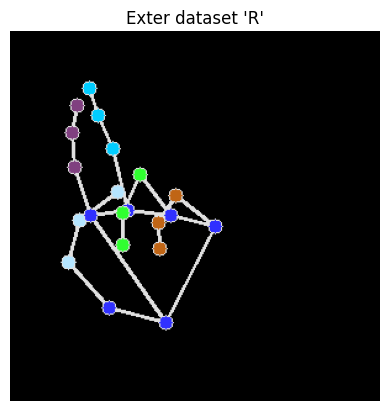

In [84]:
# plt.imshow(to_image(features))
# plt.title("Exter dataset 'R'")
# plt.axis('off')
# plt.savefig('exter_r.png', dpi=300)  # High resolution
# plt.show()

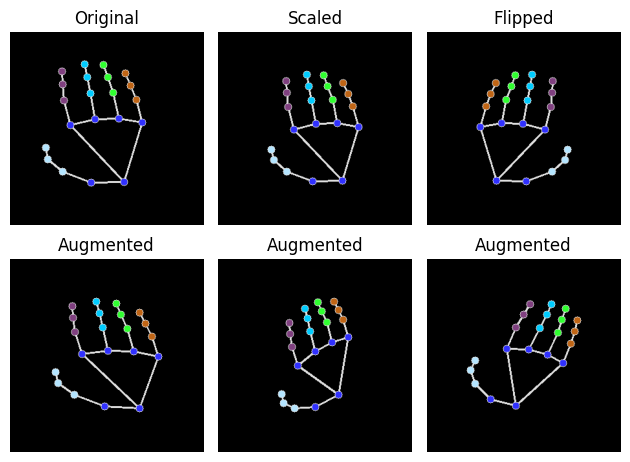

In [86]:
features = train_df.values[500, :-1].astype(np.float32)
data = augment_demo(features)

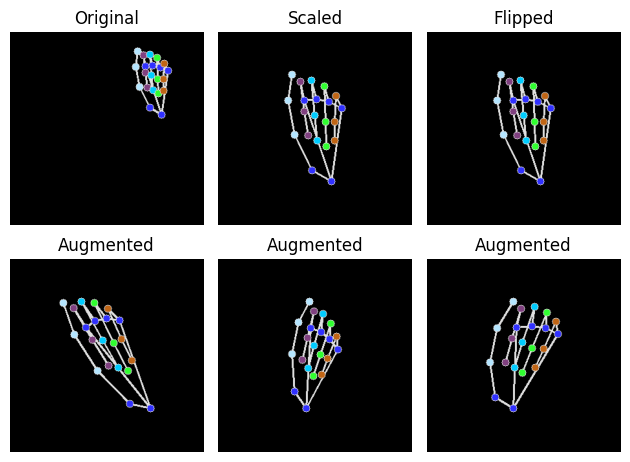

In [87]:
features = test_df.values[1000, :-1].astype(np.float32)
augment_demo(features)

## Create dataset

In [88]:
def get_dataset(csv_path, *, batch_size=1, drop_remainder=False, shuffle_size=None, repeat=False, cache=False, augment=False):
    ds = tf.data.TextLineDataset(csv_path).skip(1) # skip header
    ds = ds.map(lambda x: preprocess_csv(x, augment=augment), tf.data.AUTOTUNE)
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle_size:
        ds = ds.shuffle(shuffle_size)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)
        
    ds = ds.batch(batch_size)
    
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    if cache:
        ds = ds.cache()
    
    return ds

batch_size = 256

train_ds = get_dataset(PATH_TRAIN_DS, batch_size=batch_size, shuffle_size=4*batch_size, augment=True)
valid_ds = get_dataset(PATH_VALID_DS, batch_size=batch_size)
test_ds = get_dataset(PATH_TEST_DS, batch_size=batch_size)

In [89]:
for batch in train_ds:
    print(batch)
    break

(<tf.Tensor: shape=(256, 63), dtype=float32, numpy=
array([[ 0.7566763 ,  1.8359091 , -1.1542038 , ...,  0.39254922,
         0.19133192, -1.3285184 ],
       [ 1.3651602 ,  1.6075771 , -1.0629838 , ...,  1.5014284 ,
         0.8121386 , -1.2382892 ],
       [ 1.1509577 ,  1.6846962 , -0.9709992 , ...,  1.4799316 ,
         0.7420586 , -1.0975945 ],
       ...,
       [ 0.59757227,  1.2976855 , -0.8095547 , ...,  0.46729487,
         1.0639324 , -1.2603104 ],
       [ 0.5626482 ,  1.1001782 , -0.5464998 , ...,  0.899927  ,
         0.817591  , -1.5412467 ],
       [ 0.69027513,  1.8258451 , -1.0915527 , ...,  0.31311816,
         0.21060516, -1.4111972 ]], dtype=float32)>, <tf.Tensor: shape=(256,), dtype=int32, numpy=
array([ 1,  0,  0, 13, 15,  7,  9,  1,  8, 20,  2, 20,  8, 11, 19,  9,  2,
        5, 15,  3, 12, 16,  6,  9, 20,  5,  8,  3,  1,  4, 14, 19,  7, 22,
       21, 12, 13,  1, 10,  0,  0,  3, 21,  5, 19, 19, 20,  2, 17, 19, 12,
       16,  9,  4,  7, 15,  0,  2, 12, 15, 19, 

# Models

## Dense model

In [100]:
model = keras.Sequential([
    layers.Input(shape=(63,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(sorted_cats), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               8192      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 23)                1495      
                                                                 
Total params: 17943 (70.09 KB)
Trainable params: 17943 (70.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## CNN model

In [111]:
model = keras.Sequential([
    layers.Input(shape=(63,)),
    layers.Lambda(lambda x: keras.backend.expand_dims(x, axis=-1)),
    layers.Conv1D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(sorted_cats), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 63, 1)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 32)            128       
                                                                 
 flatten_1 (Flatten)         (None, 1952)              0         
                                                                 
 dense_15 (Dense)            (None, 128)               249984    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)               

In [112]:
%%time
history = model.fit(train_ds,
          validation_data=valid_ds,
          epochs=50,
          verbose = 2)

Epoch 1/50
179/179 - 6s - loss: 1.7266 - accuracy: 0.4546 - val_loss: 0.7137 - val_accuracy: 0.8378 - 6s/epoch - 31ms/step
Epoch 2/50
179/179 - 4s - loss: 0.8043 - accuracy: 0.7493 - val_loss: 0.4637 - val_accuracy: 0.8912 - 4s/epoch - 24ms/step
Epoch 3/50
179/179 - 4s - loss: 0.6149 - accuracy: 0.8196 - val_loss: 0.3697 - val_accuracy: 0.9125 - 4s/epoch - 24ms/step
Epoch 4/50
179/179 - 4s - loss: 0.5128 - accuracy: 0.8533 - val_loss: 0.3095 - val_accuracy: 0.9226 - 4s/epoch - 25ms/step
Epoch 5/50
179/179 - 4s - loss: 0.4554 - accuracy: 0.8719 - val_loss: 0.2877 - val_accuracy: 0.9275 - 4s/epoch - 24ms/step
Epoch 6/50
179/179 - 4s - loss: 0.4199 - accuracy: 0.8829 - val_loss: 0.2610 - val_accuracy: 0.9354 - 4s/epoch - 24ms/step
Epoch 7/50
179/179 - 4s - loss: 0.3878 - accuracy: 0.8922 - val_loss: 0.2406 - val_accuracy: 0.9350 - 4s/epoch - 24ms/step
Epoch 8/50
179/179 - 4s - loss: 0.3613 - accuracy: 0.8988 - val_loss: 0.2223 - val_accuracy: 0.9412 - 4s/epoch - 24ms/step
Epoch 9/50
179/1

In [103]:
#dense_history = history

In [106]:
#cnn_history = history

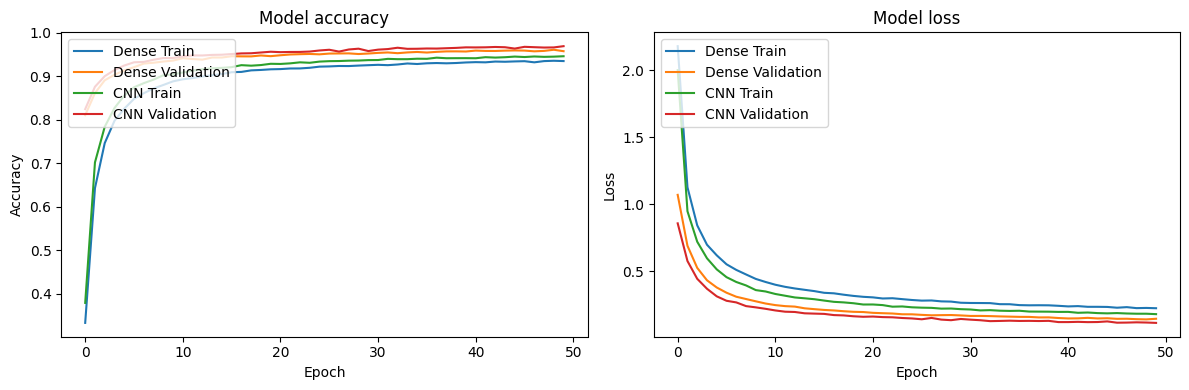

In [108]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(dense_history.history['accuracy'])
plt.plot(dense_history.history['val_accuracy'])
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Dense Train', 'Dense Validation', 'CNN Train', 'CNN Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(dense_history.history['loss'])
plt.plot(dense_history.history['val_loss'])
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Dense Train', 'Dense Validation', 'CNN Train', 'CNN Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('history.png', dpi=300)  # High resolution
plt.show()

In [323]:
#tf.saved_model.save(model, "static_fingerspelling_cnn_model")

INFO:tensorflow:Assets written to: static_fingerspelling_cnn_model\assets


INFO:tensorflow:Assets written to: static_fingerspelling_cnn_model\assets


# Evaluation

In [109]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

188/188 [==============================] - 2s 12ms/step - loss: 0.5453 - accuracy: 0.8314
Loss: 0.5453
Accuracy: 0.8314


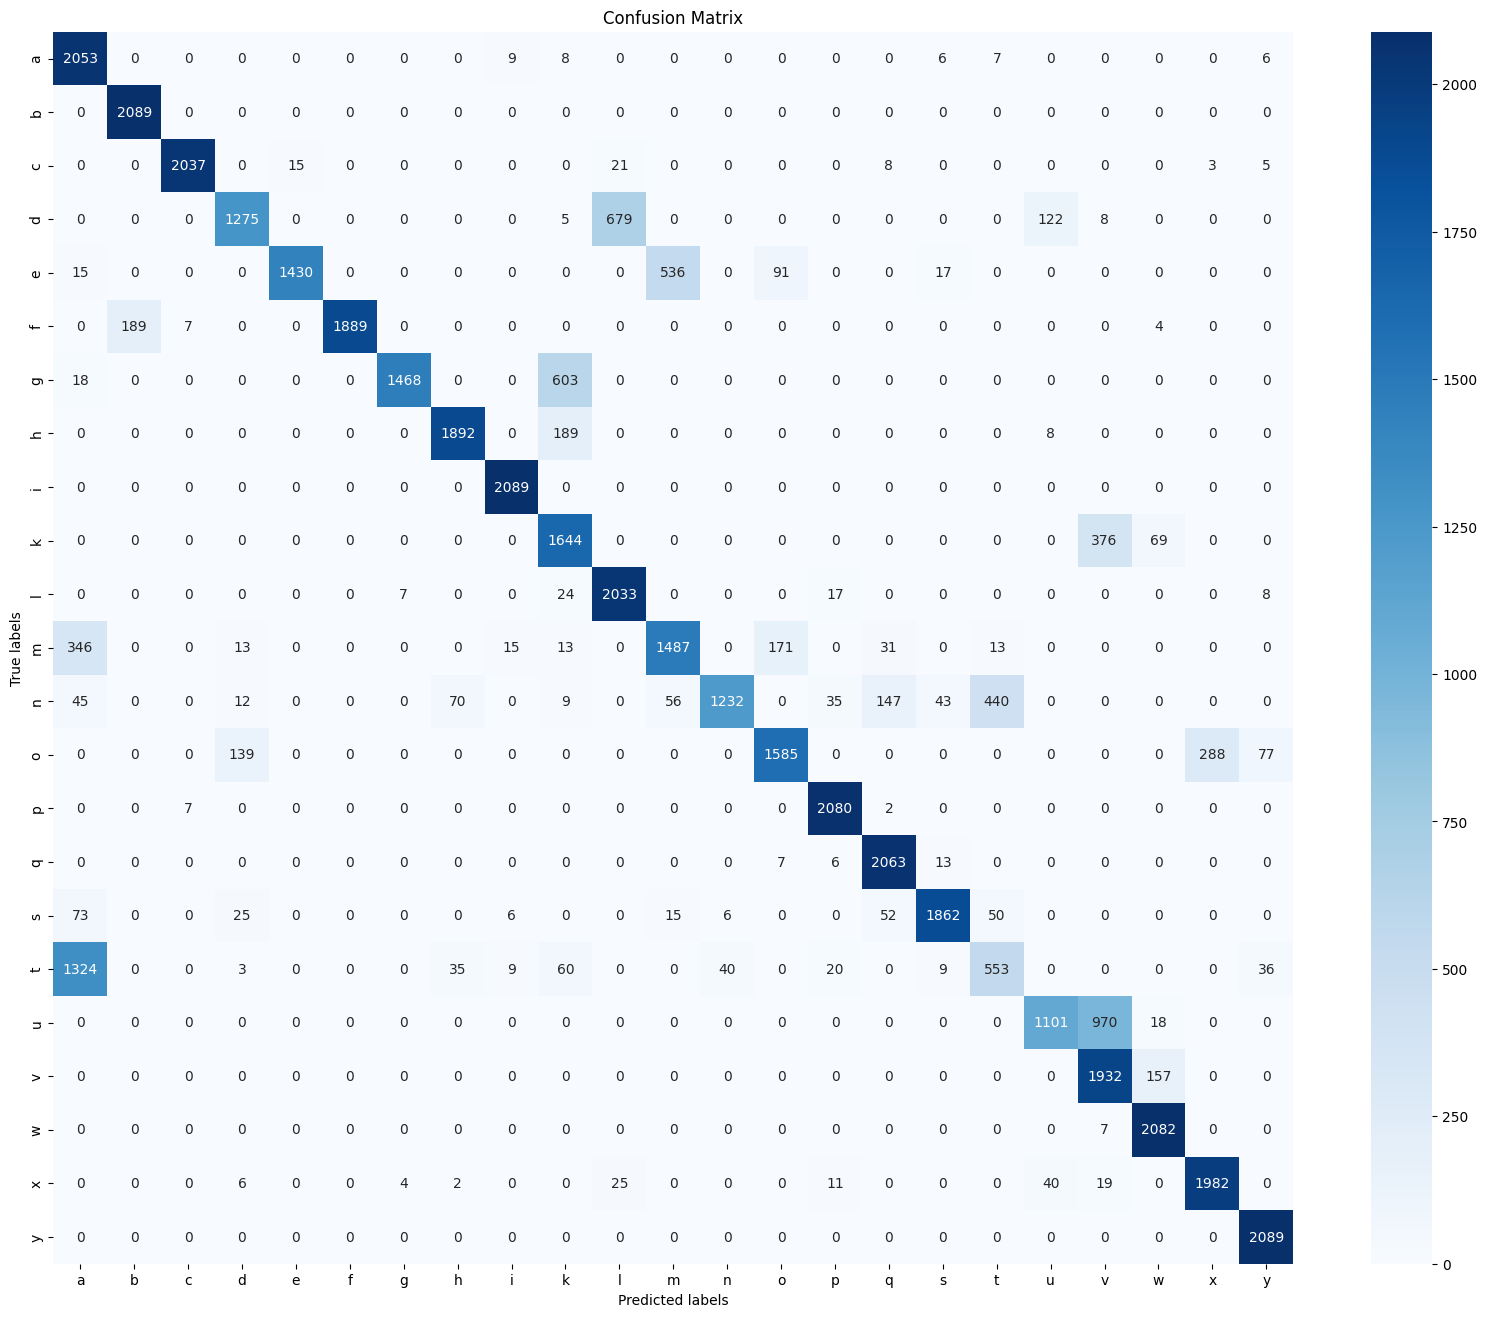

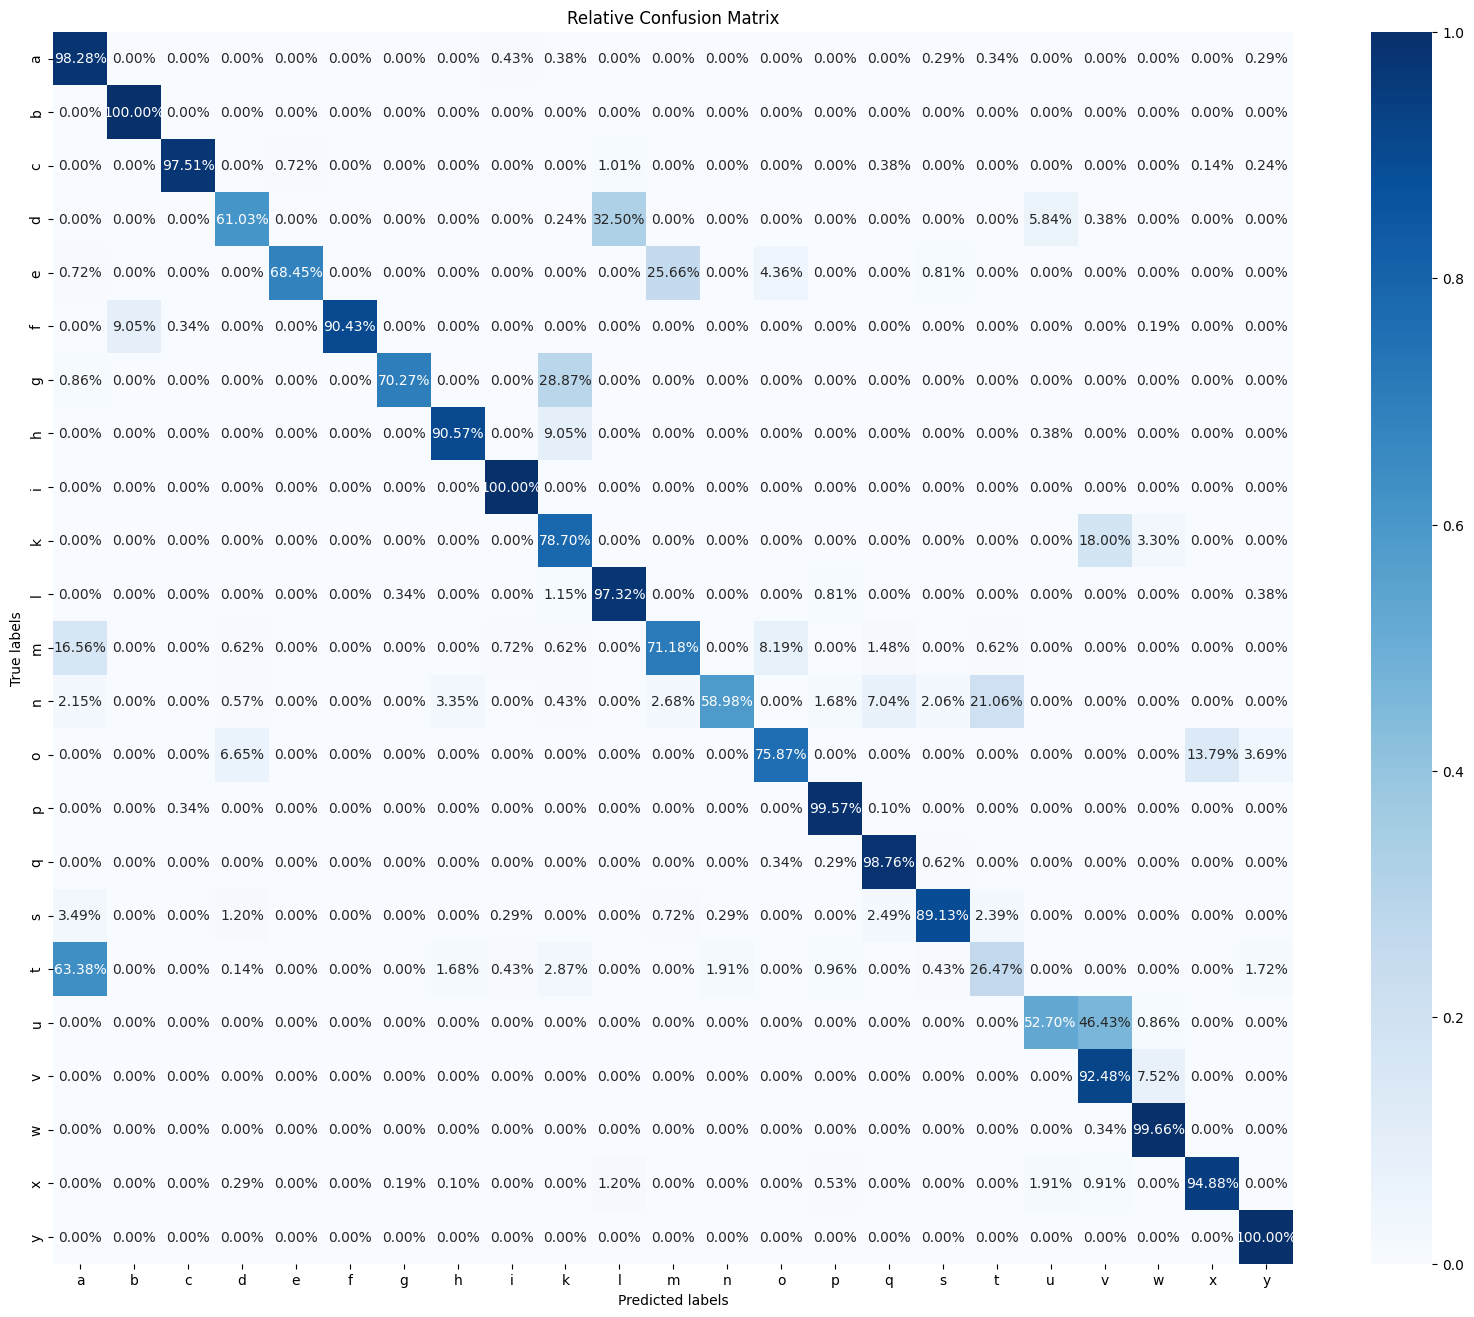

In [110]:
true_labels = []
predicted_labels = []
for lms, labels in test_ds:
    raw_preds = model.predict(lms, verbose=0)
    preds = np.argmax(raw_preds, axis=1)
    true_labels.extend([num_to_cat[num.numpy()] for num in labels])
    predicted_labels.extend([num_to_cat[num] for num in preds])
    
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=cat_to_num.keys(),
                yticklabels=cat_to_num.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('CNN Confusion Matrix.png', dpi=300)  # High resolution
plt.show()

cm = cm/cm.sum(axis=-1)[:, np.newaxis]
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues",
                xticklabels=cat_to_num.keys(),
                yticklabels=cat_to_num.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Relative Confusion Matrix')
plt.savefig('CNN Relative Confusion Matrix.png', dpi=300)  # High resolution
plt.show()

# Testing

## Util to work with video feeds using mediapipe hands

In [85]:
WEBCAM = 0

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def video_loop_mp_hands(source, process_data_func):
    video = cv2.VideoCapture(source)
    display_handle=display(None, display_id=True)
    try:
        with mp_hands.Hands(static_image_mode=True, model_complexity=1,max_num_hands=1,min_detection_confidence=0.5,min_tracking_confidence=0.5) as hands:
            while True:
                _, image = video.read()
    
                if image is None:
                    break

                image. flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = hands.process(image)
                
                if results.multi_hand_landmarks:
                    hand_landmarks = results.multi_hand_landmarks[0] # 1 hand only
    
                    # Get bounding box for the hand
                    lms = hand_landmarks.landmark
                    x_coords = [lm.x for lm in lms]
                    y_coords = [lm.y for lm in lms]
                    min_x, max_x = int(min(x_coords) * image.shape[1]), int(max(x_coords) * image.shape[1])
                    min_y, max_y = int(min(y_coords) * image.shape[0]), int(max(y_coords) * image.shape[0])

                    # Add margin proportional to width and height
                    width = max_x-min_x
                    height = max_y-min_y
                    expansion_rate = 0.4
                    min_y = max(int(min_y-expansion_rate*height), 0)
                    max_y = int(max_y+expansion_rate*height)
                    min_x = max(int(min_x-expansion_rate*width), 0)
                    max_x = int(max_x+expansion_rate*width)

                    # Crop hand image so that far away hands appear similar to images from dataset
                    hand_image = image[min_y:max_y, min_x:max_x]

                    # Collect landmark coordinates
                    data = []
                    # If the cropped hand is not too small to detect use landmarks from that image
                    if width > 0 and height > 0:
                        zoomed_result = hands.process(hand_image)
                        if zoomed_result.multi_hand_landmarks:
                            # Gather landmark coordinates
                            for lm in zoomed_result.multi_hand_landmarks[0].landmark:
                                data.extend([lm.x, lm.y, lm.z])

                    # As a fallback use the data from original image. (This won't be as accurate.)
                    if len(data) == 0:
                        for lm in lms:
                            data.extend([lm.x, lm.y, lm.z])

                    # Get prediction and probability from function
                    pred, prob = process_data_func(data)

                    # Display infographics on screen
                    # Draw landmarks
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    mp_drawing.draw_landmarks(
                        image,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp_drawing_styles.get_default_hand_landmarks_style(),
                        mp_drawing_styles.get_default_hand_connections_style())
                    
                    # Display prediction and probability near the bounding box
                    image = cv2.flip(image, 1)
                    label = f"{pred}: {prob:.2f}" if pred else "unknown"
                    cv2.putText(image, label.upper(), (image.shape[1] - min_x, min_y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2, cv2.LINE_AA)
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    image = cv2.flip(image, 1)
                
                _, image = cv2.imencode('.jpeg', image)
                display_handle.update(Image(data=image.tobytes()))
    except KeyboardInterrupt:
        pass
    finally:
        video.release()
        display_handle.update(None)

## Predict every frame model for isolated signs

In [99]:
def process_frame(frame):
    x = preprocess_lms(frame)
    probs = model(np.array([x]))
    prob = np.max(probs, axis=1)[0]
    pred = np.argmax(probs)
    pred = num_to_cat[pred]
    return pred, prob

video_loop_mp_hands(WEBCAM, process_frame)

None

## Buffered model for isolated signs

In [87]:
class BufferedModel:
    def __init__(self, model, preprocess_fn, *, confidence, buffer_size):
        self.model = model
        self.preprocess_fn = preprocess_fn
        self.buffer = deque(maxlen=buffer_size)
        self.confidence_threshold = int(buffer_size * confidence)
        self.buffer_size = buffer_size

    def process_frame(self, frame):
        x = self.preprocess_fn(frame)
        probs = self.model(np.array([x]))
        prob = np.max(probs, axis=1)[0]
        pred = np.argmax(probs)

        # Store tuple (prediction, probability) in the buffer
        self.buffer.append((pred, prob))

        # Retrieve the most common prediction from the buffer
        buffered_pred, count = Counter([item[0] for item in self.buffer]).most_common(1)[0]

        # If confidence threshold is met, compute average probability for the most common prediction
        if count >= self.confidence_threshold:
            avg_prob = sum(item[1] for item in self.buffer if item[0] == buffered_pred) / count
            return num_to_cat[buffered_pred], avg_prob

        return None, 0.

In [88]:
buffered_model = BufferedModel(model, preprocess_lms, confidence=0.7, buffer_size=10)
video_loop_mp_hands(WEBCAM, lambda data: buffered_model.process_frame(data))

None

## Buffered model with top_k and top_p parameters

In [89]:
class ProbabilisticBufferedModel:
    def __init__(self, model, preprocess_fn, *, confidence, buffer_size, top_k, top_p):
        self.model = model
        self.preprocess_fn = preprocess_fn
        self.buffer = deque(maxlen=buffer_size)
        self.confidence_threshold = int(buffer_size * confidence)
        self.buffer_size = buffer_size
        self.top_k = top_k
        self.top_p = top_p

    def process_frame(self, frame):
        x = self.preprocess_fn(frame)
        probs = self.model(np.array([x]))[0].numpy()
        
        # Sort the classes based on probabilities
        sorted_indices = np.argsort(probs)[::-1]
        
        # Select up to top_k classes whose probabilities sum up to less than top_p
        cumulative_probs = np.cumsum(probs[sorted_indices])

        # If the model is confident in the first place choice choose that
        if self.top_p < cumulative_probs[0]:
            chosen_class = sorted_indices[0]
            chosen_prob = probs[chosen_class]
        else:
            selected_indices = sorted_indices[:self.top_k][cumulative_probs[:self.top_k] <= self.top_p]
            
            # Normalize the probabilities of the selected classes
            normalized_probs = probs[selected_indices] / sum(probs[selected_indices])
            
            # Randomly select one of the classes based on their normalized probabilities
            chosen_class = np.random.choice(selected_indices, p=normalized_probs)
            chosen_prob = probs[chosen_class]
        
        # Add the chosen class and its probability to the buffer
        self.buffer.append((chosen_class, chosen_prob))

        # Retrieve the most common prediction from the buffer
        buffered_pred, count = Counter([item[0] for item in self.buffer]).most_common(1)[0]

        # If confidence threshold is met, compute average probability for the most common prediction
        if count >= self.confidence_threshold:
            avg_prob = sum(item[1] for item in self.buffer if item[0] == buffered_pred) / count
            return num_to_cat[buffered_pred], avg_prob

        return None, 0.

In [90]:
prob_buffered_model = ProbabilisticBufferedModel(model, preprocess_lms, confidence=0.7, buffer_size=10, top_k=3, top_p=0.9)
video_loop_mp_hands(WEBCAM, lambda data: prob_buffered_model.process_frame(data))

None

# Continuous model

handle words

In [92]:
class ContinuousModel:
    def __init__(self):
        self.buffered_model = ProbabilisticBufferedModel(model, preprocess_lms, confidence=0.8, buffer_size=15, top_k=3, top_p=0.9)
        self.last_pred = None
        self.word = ""

    def process_frame(self, frame):
        pred, prob = self.buffered_model.process_frame(frame)
        if self.last_pred != pred and pred is not None and prob > 0.7 and pred != "*":
            self.last_pred = pred
            self.word += pred
        return self.word, 0.

c_model = ContinuousModel()
video_loop_mp_hands(WEBCAM, lambda data: c_model.process_frame(data))

None

## Continuous model with signing detection

For this model the mediapipe holistic model is needed, gather more pose information than simply the 2 hands.

### Handle mediapipe holistic model

In [93]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def draw_landmarks_on_image(image, results):
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_pose_landmarks_style())
    mp_drawing.draw_landmarks(
        image,
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    mp_drawing.draw_landmarks(
        image,
        results.right_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    return image

def video_loop_mp_holistics(source, process_data_func):
    video = cv2.VideoCapture(source)
    display_handle=display(None, display_id=True)
    try:
        with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
            while True:
                _, frame = video.read()
    
                if frame is None:
                    break
    
                #image = cv2.resize(frame, (360, 240))
                image=frame
    
                # To improve performance, optionally mark the image as not writeable to pass by reference.
                image.flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = holistic.process(image)

                # Run the model
                process_data_func(results)
    
                # Draw landmark annotation on the image.
                image = draw_landmarks_on_image(image, results)
    
                image = cv2.flip(image, 1)
                _, image = cv2.imencode('.jpeg', image)
                display_handle.update(Image(data=image.tobytes()))
    except KeyboardInterrupt:
        pass
    finally:
        video.release()
        display_handle.update(None)

### Signing detection model

In [94]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

def extract_for_signing_detection(res):
    # Extract specific pose landmarks if available
    px = []
    py = []
    pz = []
    if res.pose_landmarks:
        for i in POSE:
            lm = res.pose_landmarks.landmark[i]
            px.append(lm.x)
            py.append(lm.y)
            pz.append(lm.z)
    else:
        px = [0.0]*len(POSE)
        py = [0.0]*len(POSE)
        pz = [0.0]*len(POSE)

    # Extract left hand landmarks if available
    lx = []
    ly = []
    lz = []
    if res.left_hand_landmarks:
        for lm in res.left_hand_landmarks.landmark:
            lx.append(lm.x)
            ly.append(lm.y)
            lz.append(lm.z)
    else:
        lx = [0.0]*21
        ly = [0.0]*21
        lz = [0.0]*21

    # Extract right hand landmarks if available
    rx = []
    ry = []
    rz = []
    if res.right_hand_landmarks:
        for lm in res.right_hand_landmarks.landmark:
            rx.append(lm.x)
            ry.append(lm.y)
            rz.append(lm.z)
    else:
        rx = [0.0]*21
        ry = [0.0]*21
        rz = [0.0]*21

    return list(chain(rx, lx, px, ry, ly, py, rz, lz, pz))

# Only load once
signing_detection_model = tf.saved_model.load("signing_detection_model")

class SigningDetectionModel:
    def __init__(self):
        self.signing_detection_model_input = list(np.zeros((15, 156)))

    def is_signing(self, inp_lm):
        self.signing_detection_model_input.pop(0)
        self.signing_detection_model_input.append(inp_lm)
        return signing_detection_model.predict(self.signing_detection_model_input)["result"].numpy() == 1

class BufferedSigningDetectionModel:
    def __init__(self, buffer_len=5, confidence_number=3):
        self.signing_detection_model_input = list(np.zeros((15, 156)))
        self.signing_detector_buffer = deque(maxlen=buffer_len)
        self.confidence_number = confidence_number 

    def is_signing(self, inp_lm):
        self.signing_detection_model_input.pop(0)
        self.signing_detection_model_input.append(inp_lm)
        pred = signing_detection_model.predict(self.signing_detection_model_input)["result"].numpy()
        self.signing_detector_buffer.append(pred)
        buffered_pred, count = Counter(self.signing_detector_buffer).most_common(1)[0]
        if count >= self.confidence_number:
            return buffered_pred == 1
        else:
            return False

In [127]:
def extract_for_static_fingerspelling(res):
    # Extract right hand landmarks if available
    data = []
    if res.right_hand_landmarks:
        for lm in res.right_hand_landmarks.landmark:
            data.append(lm.x)
            data.append(lm.y)
            data.append(lm.z)
    elif res.left_hand_landmarks:
        for lm in res.left_hand_landmarks.landmark:
            data.append(lm.x)
            data.append(lm.y)
            data.append(lm.z)
    else:
        data = [0.0]*63
        
    return data

class ContinuousModelWithSigningDetection:
    def __init__(self):
        self.signing_detection_model = BufferedSigningDetectionModel()
        self.buffered_model = BufferedModel(model, preprocess_lms, confidence=0.8, buffer_size=15)
        self.last_pred = None

    def process_result(self, mp_result):
        sd_inp = extract_for_signing_detection(mp_result)
        if self.signing_detection_model.is_signing(sd_inp):
            print("*", end="")
            pred, prob = self.buffered_model.process_frame(extract_for_static_fingerspelling(mp_result))
            if self.last_pred != pred and pred is not None:
                self.last_pred = pred
                print(pred, end="")
                return
        else:
            print("-", end="")
            self.last_pred = None

m = ContinuousModelWithSigningDetection()

video_loop_mp_holistics(WEBCAM, lambda mp_res: m.process_result(mp_res))

None

------------------------------------------------------------------------------------------*******-------------------------------------------------------------------------------------------***********************************----------------------------***********----------------------------------------------------------------------------------------------------------------------*******x************************************************************************----------------*x****---------------------------------------------*x**********-------------------------------------------------************a*****************************************b*******************************c******************************************************************d**********************************************************m*****************************************f*******************************************************q********************************g********************************************************************

### LLm improvement

In [102]:
key = os.environ.get('OPEN_AI_API_KEY')
if key is not None:
    openai.api_key = key
else:
    print("Error: Please set a valid api key!")

#### 1st prompt

In [103]:
def correct_output(pred, ):
    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo", 
       messages=[
        {"role": "system", "content": "You are a machine that tries to correct the output of a fingerspelling recognition model. Some letters might be missing, but it's also possible that the given text has extra characters. The model will always give i instead of j and z also doesn't work. Only reply with the corrected text."},
        {"role": "user", "content": "lebra"},
        {"role": "system", "content": "zebra"},
        {"role": "user", "content": "beark"},
        {"role": "system", "content": "bear"},
        {"role": "user", "content": "iagudar"},
        {"role": "system", "content": "jaguar"},
        {"role": "user", "content": pred},
      ]
    )
    
    return completion["choices"][0]["message"]["content"]

In [104]:
correct_output("iackdl")

'jackal'

In [108]:
correct_output("loom") # what happens if both are acceptable (loom, zoom, room)

'zoom'

#### 2nd prompt

In [121]:
def correct_output(pred):
    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo", 
       messages=[
        {"role": "system", "content": "You are a machine that tries to correct the output of a fingerspelling recognition model. The model can't output j and z, so only correct those two, but if the original word exists in English don't correct it. Only reply with the corrected text."},
        {"role": "user", "content": "lebra"},
        {"role": "system", "content": "zebra"},
        {"role": "user", "content": "beark"},
        {"role": "system", "content": "beark"},
        {"role": "user", "content": "iaguar"},
        {"role": "system", "content": "jaguar"},
        {"role": "user", "content": pred},
      ]
    )
    
    return completion["choices"][0]["message"]["content"]

In [122]:
correct_output("iackal")

'jackal'

In [123]:
correct_output("iiasdfasdf")

'iiasdfasdf'

In [124]:
correct_output("island")

'island'

In [125]:
correct_output("loom") # what happens if both are acceptable (loom, zoom, room)

'loom'

In [126]:
correct_output("lebra") # This is interesting as this is part of the examples.

'lebra'